In [465]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

API_KEY = "5K2C96PUQWH9YWMX"

In [471]:
# (5)
# opening and storing data

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey={API_KEY}'
r = requests.get(url)
data = r.json()

# storing in a dataframe 
df = pd.DataFrame(data['Time Series (Daily)']).T

# resetting index to have dates as a column
df.reset_index(inplace=True)

# renaming the columns
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# converting date column to datetime
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
# filtering data for specified date range 
# we'll keep the datetime the same rather than turning it into a sequence of numbers
start_date = '2023-11-07'
end_date = '2024-03-26'
df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

print(df_filtered)

# splitting into train and test sets (test = first 5 rows)
test = df_filtered.iloc[:5]
train = df_filtered.iloc[5:]

(100, 6)
         date      open      high       low     close   volume
23 2024-03-26  189.0200  190.0000  188.5000  188.5000  4229535
24 2024-03-25  190.2600  190.8200  188.7500  188.7900  3718289
25 2024-03-22  192.0000  192.9850  190.5100  190.8400  3988398
26 2024-03-21  193.0000  193.3700  190.0100  191.9000  6013561
27 2024-03-20  192.8700  193.9800  191.3100  193.9600  3238643
..        ...       ...       ...       ...       ...      ...
95 2023-12-11  162.6800  163.6500  161.9500  163.5100  6077207
96 2023-12-08  160.0000  162.0400  160.0000  161.9600  4561342
97 2023-12-07  161.0000  161.4650  159.9700  160.2200  3665498
98 2023-12-06  161.5900  162.3550  160.0100  160.2800  3356432
99 2023-12-05  160.7600  162.4700  160.7200  161.3900  4556668

[77 rows x 6 columns]


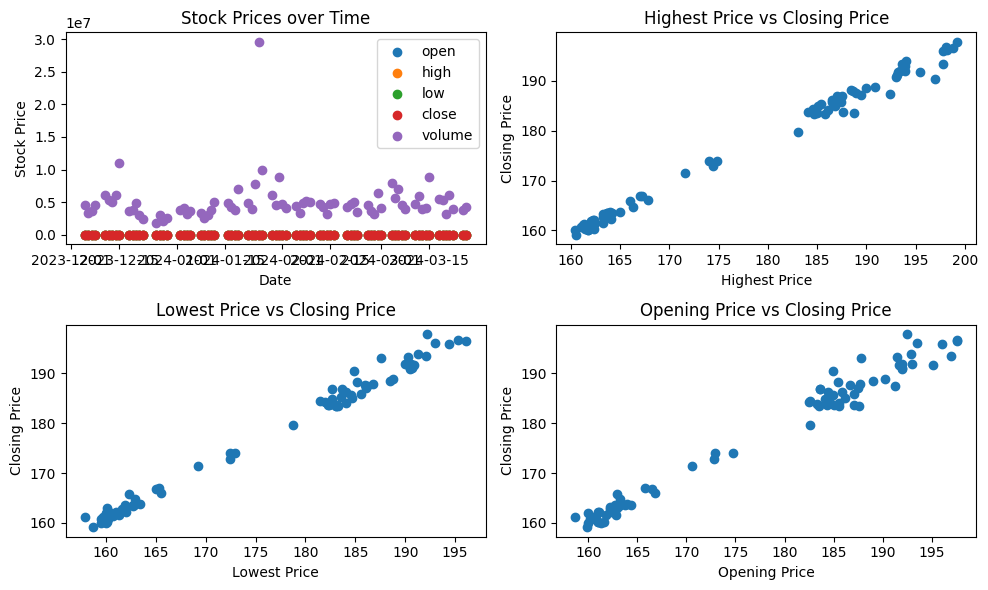

In [467]:
# (10)
# column names excluding date
column_names = ['open', 'high', 'low', 'close', 'volume']

# converting prices to numeric values (if they're not already)
df_filtered.loc[:, column_names] = df_filtered.loc[:, column_names].apply(pd.to_numeric)

# creating subplots for detailed relationships
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# plotting columns against date 
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Stock Price')
axes[0, 0].set_title('Stock Prices over Time')
for column in column_names:
    if column != 'date':
        axes[0, 0].scatter(df_filtered['date'], df_filtered[column], label=column)
axes[0, 0].legend()

# highest vs closing price
axes[0, 1].scatter(df_filtered['high'], df_filtered['close'])
axes[0, 1].set_xlabel('Highest Price')
axes[0, 1].set_ylabel('Closing Price')
axes[0, 1].set_title('Highest Price vs Closing Price')

# lowest vs closing price
axes[1, 0].scatter(df_filtered['low'], df_filtered['close'])
axes[1, 0].set_xlabel('Lowest Price')
axes[1, 0].set_ylabel('Closing Price')
axes[1, 0].set_title('Lowest Price vs Closing Price')

# opening vs closing price
axes[1, 1].scatter(df_filtered['open'], df_filtered['close'])
axes[1, 1].set_xlabel('Opening Price')
axes[1, 1].set_ylabel('Closing Price')
axes[1, 1].set_title('Opening Price vs Closing Price')

plt.tight_layout()
plt.show()

In [468]:
# (15)
'''
Now that we’ve visualized our data, let's make a few conjectures about what to expect from our linear regression model. 
For each of the variable relationships you graphed above, which of them display a linear relationship? 
Which do not? Why or why not? 
'''

# Answer
'''
Of the graphs above, highest vs closing, lowest vs closing, and opening vs closing all display a linear relationship. 
In these graphs, the points tend to form a roughly straight line, showing a clear trend. 
The clustering of points around a sort of trend line indicate that there's a consistent relationship between the variables being plotted.

The graph displaying the relationship between stock price and date does not display a linear relationship.
The plot illustrates fluctuations, trends, and some irregular patterns over time. 
The data points are scattered across the plot and do not form a clear linear trend. 
It suggests that the relationship between stock price and date is more complex and dynamic, influenced by various factors.
'''

"\nOf the graphs above, highest vs closing, lowest vs closing, and opening vs closing all display a linear relationship. \nIn these graphs, the points tend to form a roughly straight line, showing a clear trend. \nThe clustering of points around a sort of trend line indicate that there's a consistent relationship between the variables being plotted.\n\nThe graph displaying the relationship between stock price and date does not display a linear relationship.\nThe plot illustrates fluctuations, trends, and some irregular patterns over time. \nThe data points are scattered across the plot and do not form a clear linear trend. \nIt suggests that the relationship between stock price and date is more complex and dynamic, influenced by various factors.\n"

/var/folders/_2/3hjp0rz922x6krlgp71xz0v00000gp/T/ipykernel_55392/568384327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newR['ones'] = np.ones(len(train))


high    0.336083
open    0.333049
low     0.330678
ones    0.001879
dtype: object
Bias-> 0.0018791966372498268 , High Weight-> 0.3360826715209205 , Open Weight-> 0.33304865316416066 , Low Weight-> 0.33067832194824903


/var/folders/_2/3hjp0rz922x6krlgp71xz0v00000gp/T/ipykernel_55392/568384327.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Bias->",theta[3],", High Weight->",theta[0],", Open Weight->",theta[1],", Low Weight->",theta[2])


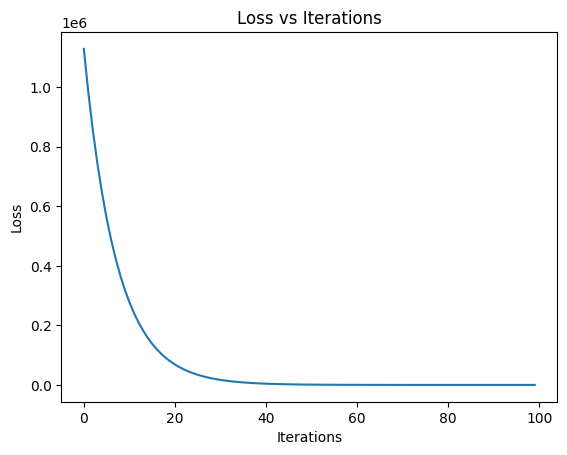

In [469]:

newR = train[['high', 'open', 'low']]
newR['ones'] = np.ones(len(train))

# print(newR)
# Fit the linear regression model using gradient descent
def grad_descent(X, y, T, alpha):
    m, n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        f[i] = 0.5 * np.linalg.norm(X.dot(theta) - y) ** 2
        g = np.transpose(X).dot(X.dot(theta) - y)
        theta = theta - alpha * g
    return (theta, f)

y = train['close'] # Dependent variable (close)

# Gradient Descent Parameters
T1 = 100
alpha1 = 0.00000001

# Fit the linear regression model using gradient descent
theta, func = grad_descent(newR, y, T1, alpha1) # regression for high and close

print(theta)

print("Bias->",theta[3],", High Weight->",theta[0],", Open Weight->",theta[1],", Low Weight->",theta[2])

plt.plot(range(T1), func)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss vs Iterations")
plt.show()

In [470]:
print(theta)
theta = np.array(theta)
# print(theta.dtype)
# print(isinstance(theta, np.ndarray))
x = np.array(test[['high', 'open', 'low']].values)
# print(x.dtype)
# print(isinstance(x, np.ndarray))
# print(x)
y = test['close'].values # Dependent variable (close)
print(y)
y_h = np.dot(x, theta[:-1])+ theta[-1]
print(x)
print(theta[:-1])
mse = np.mean((y-y_h)**2)
print("Actual Values: ", y)
print("Predicted Values: ", y_h)
print("Mean Squared Error: ", mse)

high    0.336083
open    0.333049
low     0.330678
ones    0.001879
dtype: object
[188.5 188.79 190.84 191.9 193.96]
[[190.0 189.02 188.5]
 [190.82 190.26 188.75]
 [192.985 192.0 190.51]
 [193.37 193.0 190.01]
 [193.98 192.87 191.31]]
[0.3360826715209205 0.33304865316416066 0.33067832194824903]
Actual Values:  [188.5 188.79 190.84 191.9 193.96]
Predicted Values:  [189.14330689394674 189.91454459500451 191.80366208198186
 192.10076340270743 192.6923593259566]
Mean Squared Error:  0.8508615473117545


The predicted and actual values are very close given each corresponding value has a margin of error of at most 2.  Given that information, the lack of differenctiation between the predicted and actual values can resonably infer why the mean squared error value was small.